In [1]:
from recognizer import *
import cv2
import numpy as np

## Funkcje pomocniczne do wczytywania obrazów

In [2]:
ocr = Recognizer(sans=True)
example_path = 'data/sans/a.png'
image_path = 'data/sans/facebook.png'

#### Wczytywanie obrazu w trybie Integer (greyscale)

In [3]:
imageMat = ocr.readImage(example_path)
imageMat.shape

(57, 46)

#### Wyświetlanie obrazu

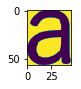

In [4]:
ocr.showImage(imageMat, 1)

#### Odwrócenie kolorów obrazu

In [5]:
imageMat = ocr.invertImage(imageMat)
imageMat.shape

(57, 46)

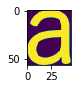

In [6]:
ocr.showImage(imageMat, 1)

## Przetwarzanie obrazu przed OCR

#### Obraz testowy

In [3]:
text = 'facebook ceo mark zuckerberg on thursday said his annual personal challenge this year will be tacking abuse, hate, foreign interference, and other major problems on facebook. in essence his 2018 will be dedicated to fixing a mess that mightve been prevented with a little more foresight by the social giant. its a departure from previous challenges, many of which have been more ligthhearted.'

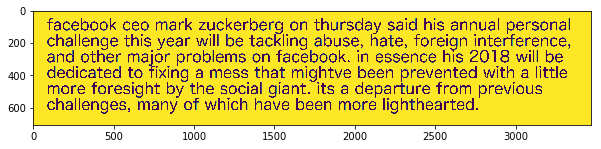

In [8]:
image = ocr.readImage(image_path)
ocr.showImage(image, 10)

#### Przykładowe dopasowanie litery do obrazu testowego

In [9]:
letterImage = ocr.fontImages['a']
correlationMatrix = ocr.correlateLetter(ocr.image, letterImage, 254, threshold=0.85)
letterPosition = ocr.getLetterPositions(correlationMatrix, letterImage)
print("Dopasowane litery a :",len(letterPosition))
print("Liczba wystąpień a w tekscie : ", text.count('a'))


Dopasowane litery a : 27
Liczba wystąpień a w tekscie :  27


#### Usunięcie dopasowaniej litery przed przetworzeniem następnej

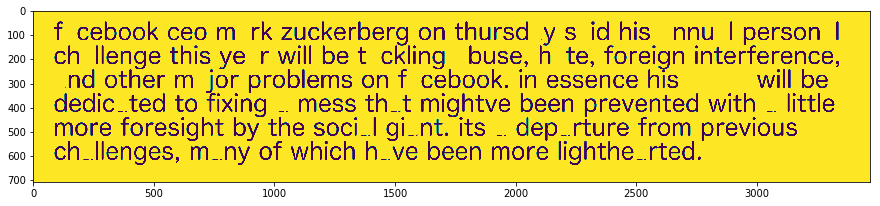

In [10]:
letterImage = ocr.fontImages['a']
correlationMatrix = ocr.correlateLetter(ocr.image, letterImage, 254, threshold=0.85)
letterPosition = ocr.getLetterPositions(correlationMatrix, letterImage)
ocr.removeLetter('a', letterPosition)
ocr.showImage(ocr.image, 15)

## Problemy z naiwnym przetwarzaniem kolejnych liter

* Obrazy niektórych liter zawierają się w innych literach
    ```'c' zawiera się w 'c', 'b', 'd', 'e' ...```
* Litery ``` 'c', 'e', 'o'``` są najtrudniejsze do dopasowania w tej czcionce
    
## Rozwiązanie

* Odpoweidnia kolejność przetawrzania liter ma największe znaczenie 
* Przed przetworzeniem obrazu, należy policzyć liczbę dopasowań pojedyńczej litery w pozostałe litery alfabetu
* Ustawić litery w kolejności rosnącej ilości dopasowań, oraz dodatkowo w kolejności rosnącej ilości dopasowań danej litery w przetwarzanym obrazie

```
[('x', 1), ('z', 1), ('w', 1), ('y', 1), ('f', 1), ('k', 1), ('g', 8),
 ('b', 2), ('p', 8), ('m', 1), ('a', 1), ('t', 1), ('u', 1), ('s', 1),
 ('j', 2), ('v', 2), ('h', 2), ('d', 8), ('l', 8), ('e', 8), ('c', 8),
 ('n', 3), ('r', 3), ('o', 8), ('q', 8), ('i', 5)]```
                     
* Dodatkowo dla każdej litery dobieram indywidualnie ```threshold```

```corrCoefficient = 5 * element[1] / self.maxf / 100```

``` ocr.correlateLetter(ocr.image, letterImage, 254, threshold=0.8 + corrCoefficient)```

## Wnioski / Uwagi
* Przy korzystaniu z obrazów o niskiej rozdzielczości, dopasowanie było bardzo słabe
* Wadą czcionki o wysokiej rozdzielczości był długi czas przetwarzania obrazu ``` 20 sekund na znak```
* Z tego powodu zrezygnowałem z dopasowywania cyfr

## Rotacja


In [11]:
def rotate_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.bitwise_not(gray)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    coords = np.column_stack(np.where(thresh > 0))
    angle = cv2.minAreaRect(coords)[-1]
    
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
        
    h, w = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated

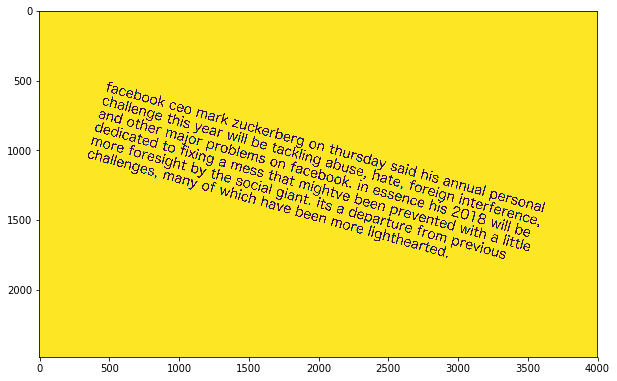

In [12]:
rot = ocr.readImage('data/sans/facebook_rot.png')
ocr.showImage(rot, 10)

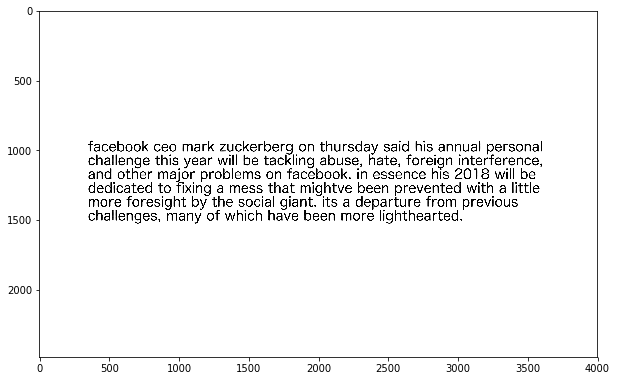

In [13]:
image = cv2.imread('data/sans/facebook_rot.png')    
image = rotate_image(image)
ocr.showImage(image, 10)

## Właściwe dopasowanie liter

In [14]:
def matchAllLetters(self):
    for element in self.orderAndFreq:
        letter = element[0]
        letterImage = self.fontImages[letter]
        corrCoefficient = 5 * element[1] / self.maxf / 100
        correlation = self.correlateLetter(self.image, letterImage, 254, threshold=0.8 + corrCoefficient)
        self.lettersPositions[letter] = self.getLetterPositions(correlation, letterImage)
        self.removeLetter(letter, self.lettersPositions[letter])

## Stworzenie tekstu na podstawie dopasowanych pozycji liter

#### Sortowanie wyznaczonych pozycji najpierw po wierszu następnie po kolumnie

In [15]:
def sortPositions(self, postions):
    positions = []
    for k, v in self.lettersPositions.items():
        for e in v:
            positions.append((k, e[0] - e[0] % 100, e[1]))
    positions = sorted(positions, key=lambda e: (e[1], e[2]))
    return positions

#### Przetworzenie posortowanych dopasowań w tekst

In [8]:
def positionsToText(self, positions):
    text = ""
    space = ocr.readImage('data/sans/space.png').shape[1]*2
    line = 99
    for i in range(len(positions) - 1):
        text += positions[i][0]
        if abs(positions[i][2] - positions[i + 1][2]) > space: # spacja
            text += chr(32)
        if abs(positions[i][1] - positions[i + 1][1]) >= line: # nowa linia
            text += '\n'
    print(text)

In [4]:
ocr.matchAllLetters()
result = ocr.positionsToText()
print(result)

facebook ceo mark zuckerberg on thursday said his annual personal 
challenge this year will be tackling abuse hate foreigninterference 
and other major proble ms on facebook qn essence his will be 
dedicated to fixing a mess that mightve been prevented with alittle 
more foresight by the social giant its a departure fro m previous 
challenges many of which have been morelighthearte


In [5]:
def error(res, ori):
    result = {}
    for letter in [chr(i) for i in range(97, 123)]:
        o = ori.count(letter)
        r = res.count(letter)
        print(letter.upper(), r, "for", o)
    return result        

In [6]:
error(result, text)

A 27 for 27
B 10 for 10
C 12 for 12
D 8 for 9
E 47 for 47
F 8 for 8
G 10 for 10
H 18 for 18
I 22 for 23
J 1 for 1
K 5 for 5
L 16 for 15
M 9 for 9
N 20 for 20
O 20 for 20
P 5 for 5
Q 1 for 0
R 21 for 21
S 17 for 17
T 22 for 22
U 6 for 6
V 4 for 4
W 4 for 4
X 1 for 1
Y 4 for 4
Z 1 for 1


{}

## Wnioski

* Najważniejszym elementem algorytmu było wybranie odpowiedniej kolejności przetwarzania liter. Zależy ona od czcionki i od przetwarzanego obrazu
* Właściwe dopasowanie wymagało drobnych ręcznych zmian, których mój program nie wykrył - np. zamiana kolejności przetarzania liter ``` o``` i ```c```
* Nie udało mi się ułożyć uniwersalnego algorytmu, poprawnie ukłądającego kolejność liter
* Nie uwzględniłem cyfr ze względu na dłuższy czas przetawrzania